In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product

In [25]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions_Marambaia.csv"

In [27]:
df = pd.read_csv('Interpolado_Marambaia.csv', sep=',', encoding='latin1')
df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",datetime
0,0.0,1021.400000,1021.400000,1021.100000,0.0,18.200000,15.700000,18.200000,18.0,15.800000,15.40,86.000000,85.0,86.0,28.0,3.8,2.000000,2002-11-08 00:00:00
1,0.0,1021.900000,1022.000000,1021.400000,0.0,18.500000,16.200000,18.600000,18.2,16.300000,15.70,87.000000,85.0,87.0,348.0,5.9,2.500000,2002-11-08 01:00:00
2,3.6,1021.700000,1022.500000,1021.700000,0.0,17.800000,15.900000,18.500000,17.6,16.400000,15.40,89.000000,86.0,89.0,17.0,6.1,2.500000,2002-11-08 02:00:00
3,0.0,1020.900000,1021.700000,1020.900000,0.0,17.400000,15.700000,17.800000,17.4,15.900000,15.70,90.000000,89.0,90.0,29.0,3.0,1.800000,2002-11-08 03:00:00
4,0.0,1020.300000,1020.800000,1020.300000,0.0,17.200000,15.600000,17.400000,17.2,15.800000,15.60,91.000000,90.0,91.0,2.0,3.9,2.400000,2002-11-08 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191083,0.0,1017.600000,1017.600000,1017.400000,789.3,21.800000,17.500000,22.500000,21.7,17.700000,16.70,77.000000,70.0,77.0,129.0,5.8,3.500000,2025-05-31 19:00:00
191084,0.0,1018.000000,1018.000000,1017.600000,312.0,21.300000,17.600000,21.900000,21.2,18.100000,17.40,81.000000,76.0,80.0,135.0,5.2,1.900000,2025-05-31 20:00:00
191085,0.0,1018.500000,1018.500000,1018.000000,9.0,20.700000,17.800000,21.400000,20.7,18.400000,17.50,84.000000,79.0,83.0,97.0,5.8,1.400000,2025-05-31 21:00:00
191086,0.0,1019.088889,1019.088889,1018.533333,0.0,20.009091,18.066667,21.009091,20.2,18.585714,17.35,85.857143,78.0,86.0,47.0,7.6,2.376190,2025-05-31 22:00:00


Partição precipitação, temperatura e umidade, respectivamente

In [28]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

In [29]:
X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

In [30]:
X_umid = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_umid = df['UMIDADE RELATIVA DO AR, HORARIA (%)']

Funções

In [31]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()

In [32]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

Precipitação xgboost

In [33]:
X_train, X_test, y_train, y_test = split_train_test(X_prec, y_prec, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost precipiptation train 0.8",
    output_file='./codecarbon_emissions_Marambaia.csv',
    log_level = "critical"
)

tracker.start()

prec_model, prec_predictions, prec_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [05:21<00:00,  1.32s/it]


Best parameters found:
{'max_depth': 4, 'eta': 0.01, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 1.0616422210287693
emissions=2.5961224977093925e-05


In [34]:
evaluate_model(y_test, prec_predictions)

MAE: 0.26604326998383027
MSE: 1.0616422210287693
MRSE: 1.0303602384742772


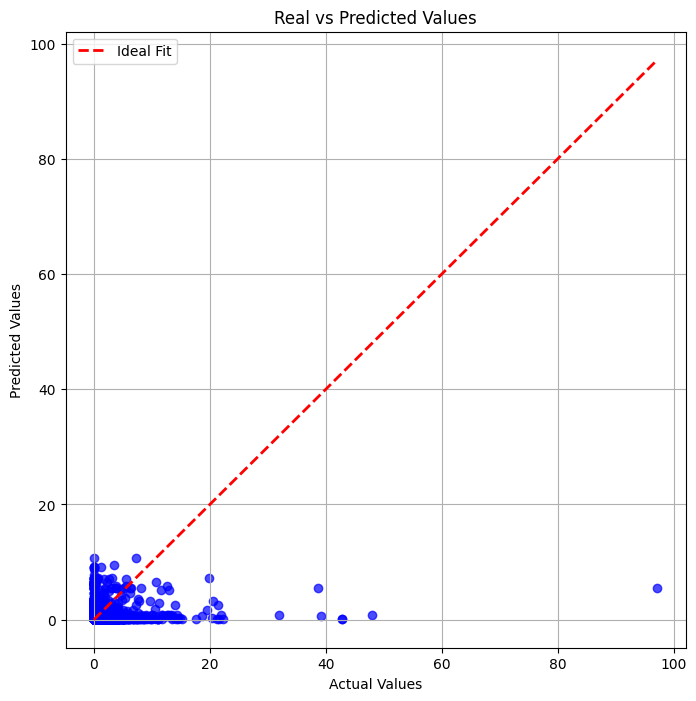

In [35]:
plot_real_vs_predicted(y_test, prec_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_geral_Marambaia.png')


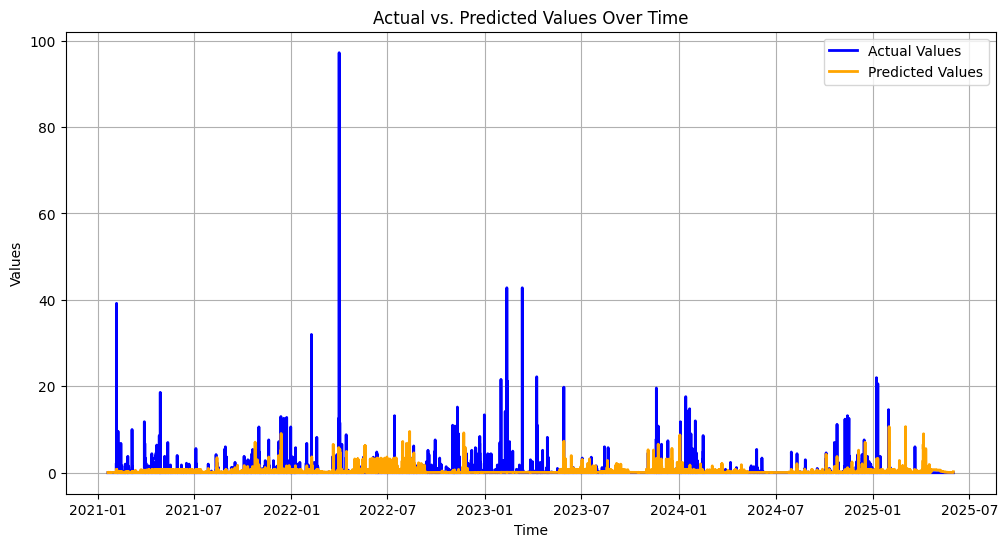

In [36]:
plot_prediction_over_time(y_test, prec_predictions, timestamps_test)


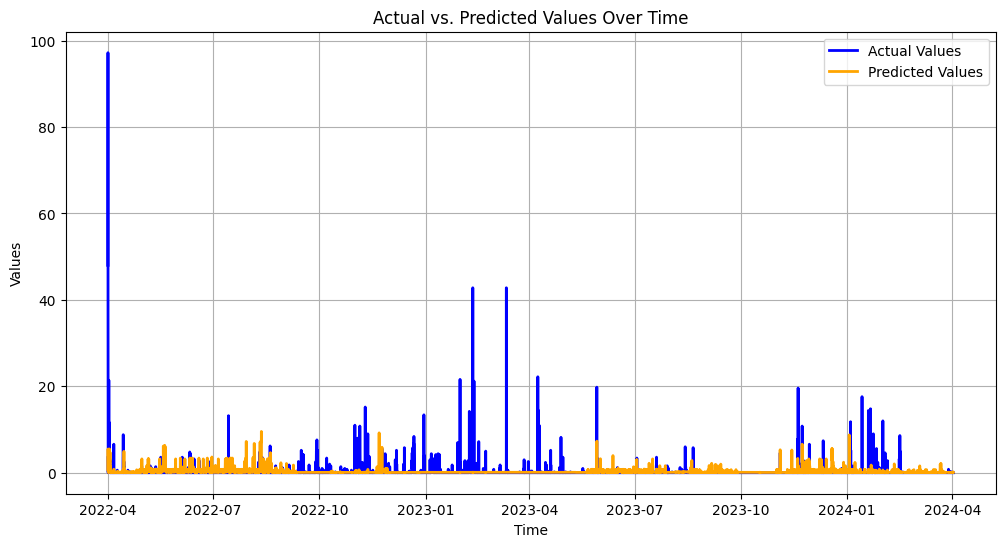

In [40]:
start_date = "2022-04-01 01:00:00"
end_date = "2024-04-01 23:00:00"

plot_prediction_over_time(y_test, prec_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_03-2024_marambaia.png')

Temperatura xgboost

In [41]:
X_train, X_test, y_train, y_test = split_train_test(X_temp, y_temp, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost temperature train 0.8",
    output_file='./codecarbon_emissions_Marambaia.csv',
    log_level = "critical"
)

tracker.start()

temp_model, temp_predictions, temp_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [04:23<00:00,  1.08s/it]


Best parameters found:
{'max_depth': 4, 'eta': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 5.246435873565978
emissions=2.13072698362893e-05


In [42]:
evaluate_model(y_test, temp_predictions)

MAE: 1.807956173974827
MSE: 5.246435873565978
MRSE: 2.2905099592811156


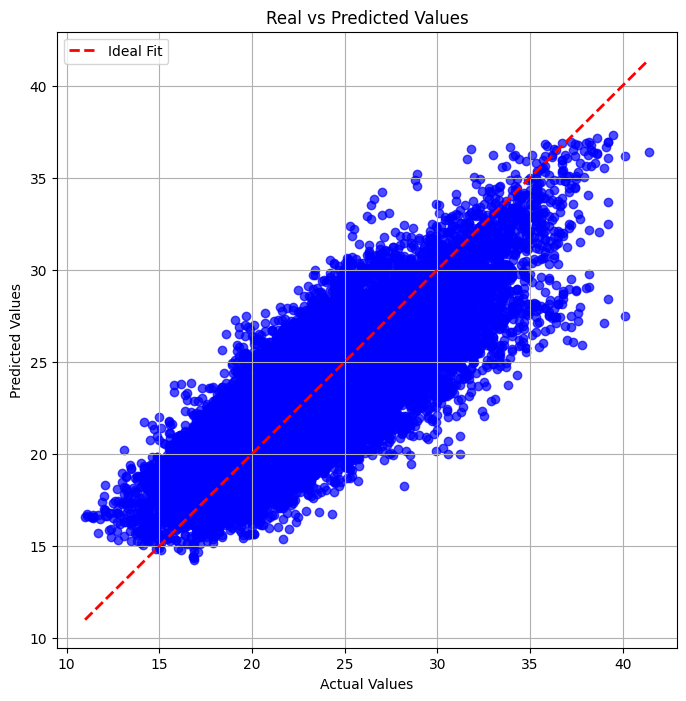

In [43]:
plot_real_vs_predicted(y_test, temp_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_geral_Marambaia.png')


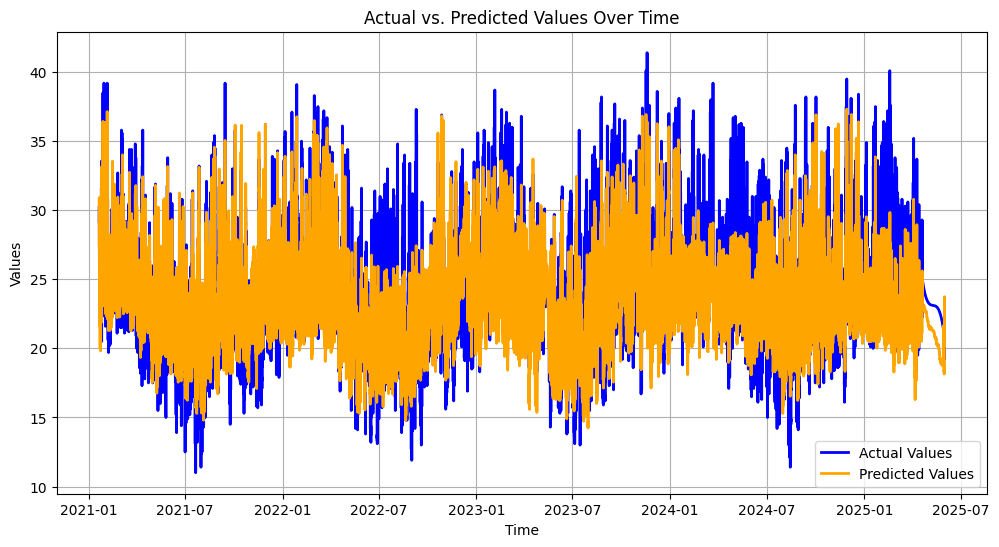

In [44]:
plot_prediction_over_time(y_test, temp_predictions, timestamps_test)

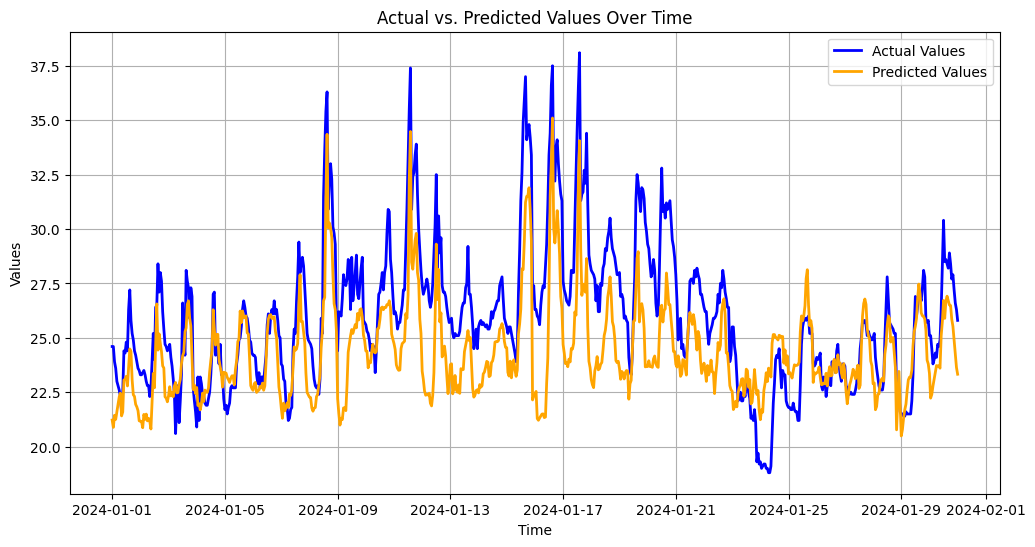

In [45]:
start_date = "2024-01-01"
end_date = "2024-01-31"

plot_prediction_over_time(y_test, temp_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_2024-01_Marambaia.png')

Umidade xgboost

In [46]:
X_train, X_test, y_train, y_test = split_train_test(X_umid, y_umid, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost umidity train 0.8",
    output_file='./codecarbon_emissions_Marambaia.csv',
    log_level = "critical"
)

tracker.start()

umid_model, umid_predictions, umid_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [04:59<00:00,  1.23s/it]


Best parameters found:
{'max_depth': 6, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 132.37655945819634
emissions=2.422518262424354e-05


In [47]:
evaluate_model(y_test, umid_predictions)

MAE: 7.035945403590484
MSE: 132.37655945819634
MRSE: 11.505501269314447


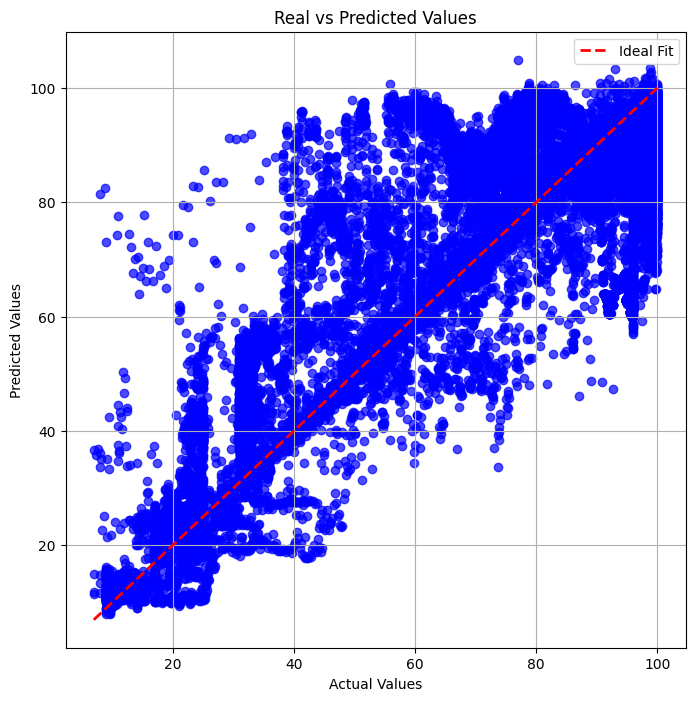

In [48]:
plot_real_vs_predicted(y_test, umid_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_geral_Marambaia.png')


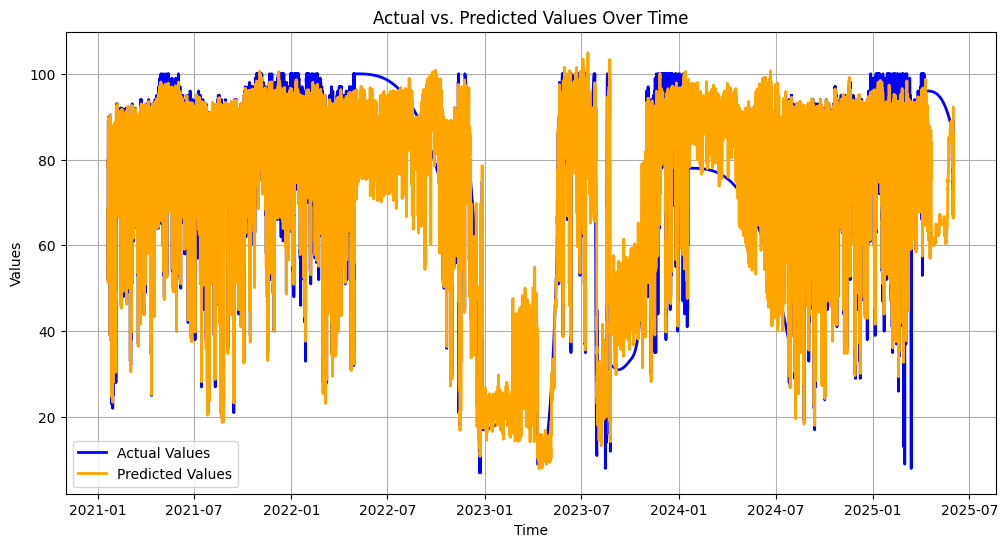

In [49]:
plot_prediction_over_time(y_test, umid_predictions, timestamps_test)

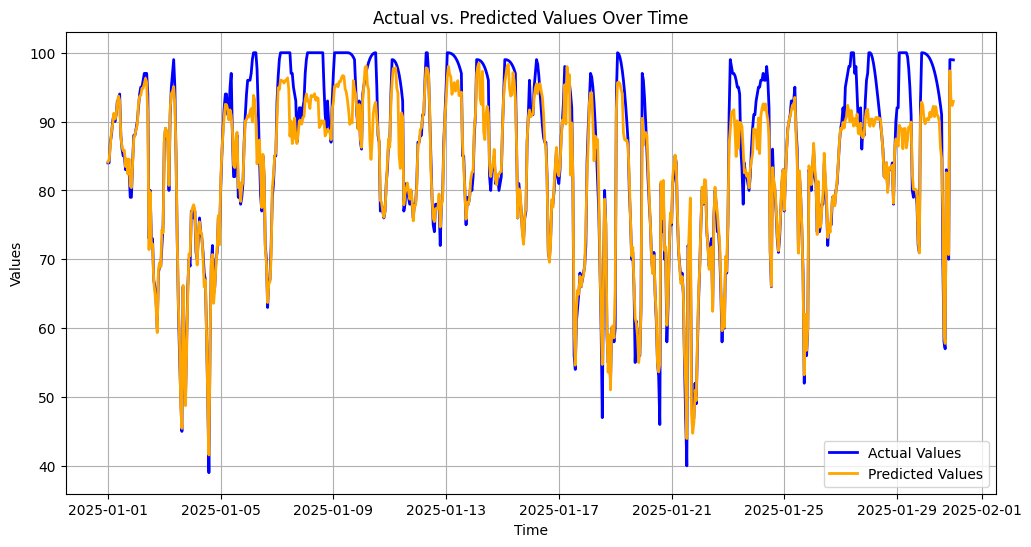

In [50]:
start_date = "2025-01-01"
end_date = "2025-01-31"

plot_prediction_over_time(y_test, umid_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_2024-01_Marambaia.png')